# Prepare data

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv("train.csv", header = 0)

value_counts = df.Id.value_counts()
# List of targets with one sample to be removed
to_remove = (value_counts == 1).index

# remove targets with one sample
df = df[df['Id'].isin(to_remove)]

# Top 3 labels
top_hitters = value_counts.nlargest(5).index
df = df[df['Id'].isin(top_hitters)]

with pd.option_context('display.max_rows', 2, 'display.max_columns', 2):
    print(df)

X = [os.path.join(os.getcwd(), 'train', s) for s in df.Image]
y = df.Id.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train = X
y_train = y

classes = df.Id.unique()
num_classes = len(classes)

print('\nThere are %d total classes.' % num_classes)
print('There are %d total images.' % len(X))

print('There are %d training images.' % len(X_train))
print('There are %d validation images.' % len(X_valid))
print('There are %d test images.' % len(X_test))

             Image         Id
1     000466c4.jpg  w_1287fbc
...            ...        ...
9844  ffd1e7aa.jpg  new_whale

[920 rows x 2 columns]

There are 5 total classes.
There are 920 total images.
There are 920 training images.
There are 129 validation images.
There are 276 test images.


# Visualize the First 8 Training Images

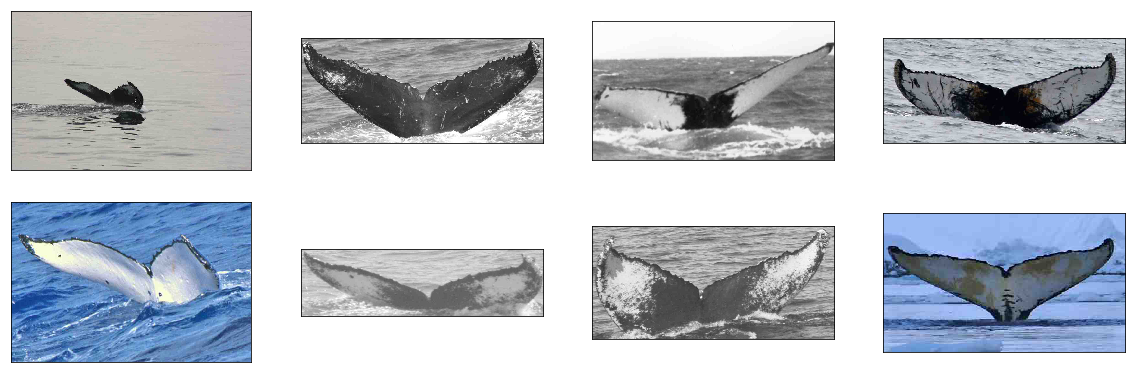

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(8):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(X_train[i], ax)

# Prepare Dataset for ImageDataGenerator

In [3]:
import shutil
import pathlib
import os

def copy_class_of_files(files, dst):
    for idx, val in enumerate(files):
        dst_dir = os.path.join(dst, y_train[idx])
        pathlib.Path(dst_dir).mkdir(parents=True, exist_ok=True)
        shutil.copy(val, dst_dir)
        
shutil.rmtree('./data', ignore_errors=True)
copy_class_of_files(X_train, 'data/train')
copy_class_of_files(X_valid, 'data/valid')
copy_class_of_files(X_test, 'data/test')

# Load CNN without top layer

In [4]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

# define InceptionResNetV2 model
image_side_size = 299
image_dim = (image_side_size, image_side_size, 3)
base_model = InceptionResNetV2(weights='imagenet', include_top=False,
                          input_tensor=None, input_shape = image_dim, 
                          pooling=None)
for layer in base_model.layers:
    layer.trainable = False
                      
# Train several last layers in base model
# for layer in base_model.layers[-22:]:
#     layer.trainable = True
    
base_model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 8, 8, 192)    576         conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 8, 8, 192)    0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 8, 8, 224)    129024      activation_189[0][0]             
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 8, 8, 224)    672         conv2d_190[0][0]                 
__________________________________________________________________________________________________
activation_190 (Activation)     (None, 8, 8, 224)    0           batch_normalization_190[0][0]    
__________

# Top layer specific to our problem

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

# Define image generators

In [7]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
target_size = (image_side_size, image_side_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size,
        shuffle=True)

valid_generator = valid_datagen.flow_from_directory(
        'data/valid',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size)

Found 920 images belonging to 5 classes.
Found 129 images belonging to 5 classes.


In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

best_weights_path='whale.flukes.weights.best.hdf5'

# train the model
checkpointer = ModelCheckpoint(filepath=best_weights_path, verbose=1, save_best_only=True)

# Stop the training if the model shows no improvement 
stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, mode='auto')

model.fit_generator(generator=train_generator,
                    epochs=1,
                    steps_per_epoch = int(len(X_train)/batch_size),
                    validation_data=valid_generator, 
                    validation_steps = int(len(X_valid)/batch_size),
                    callbacks=[checkpointer, stopper], verbose=1, workers=8)


Epoch 1/1
28/28 [==============================] - 476s 17s/step - loss: 0.4296 - acc: 0.8829 - val_loss: 0.5795 - val_acc: 0.8984

Epoch 00001: val_loss improved from inf to 0.57955, saving model to whale.flukes.weights.best.hdf5


# Load the Model with the Best Validation Loss

In [10]:
model.load_weights(best_weights_path)

# Calculate Classification Accuracy on Test Set

In [13]:
workers = 8

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    "data/test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', shuffle=False)

score = model.evaluate_generator(
    generator=test_generator, 
    steps=len(X_test)/batch_size,
    workers=workers)

print("Loss: ", score[0], "Accuracy: ", score[1])

scores = model.predict_generator(
    generator=test_generator, 
    steps=len(X_test)/batch_size,
    workers=workers)

Found 276 images belonging to 5 classes.
Loss:  0.743379309557 Accuracy:  0.880434782609
